# Feature extraction

In [85]:
IMG_1="saved_frames/frame_20250710_185738.jpg"
IMG_2="saved_frames/frame_20250710_185741.jpg"

## Harris Corners
- https://docs.opencv.org/4.x/dc/d0d/tutorial_py_features_harris.html

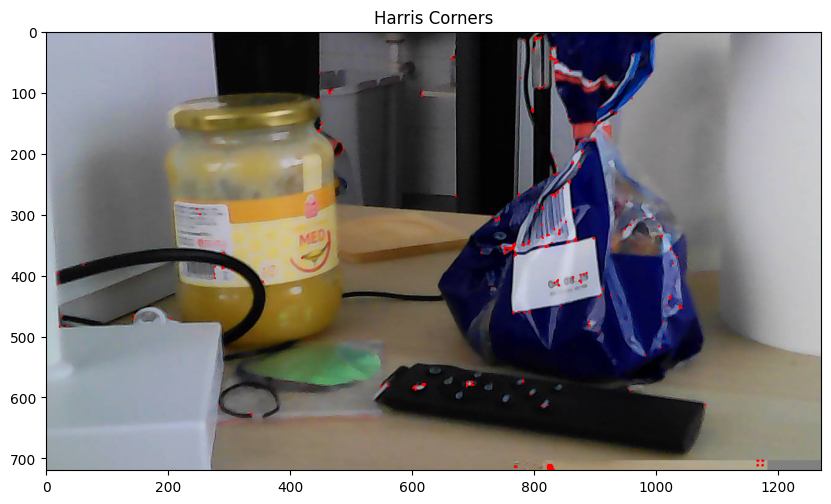

In [86]:
from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv

filename = IMG_1
img = cv.imread(filename)
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

gray = np.float32(gray)
dst = cv.cornerHarris(gray,2,3,0.04)

#result is dilated for marking the corners, not important
dst = cv.dilate(dst,None)

# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]

# show the result in the notebook
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title('Harris Corners')
plt.show()

## ORB feature extraction
- feature extraction and matching - https://docs.opencv.org/4.x/db/d27/tutorial_py_table_of_contents_feature2d.html
- ORB - https://docs.opencv.org/4.x/d1/d89/tutorial_py_orb.html

### Feature extraction

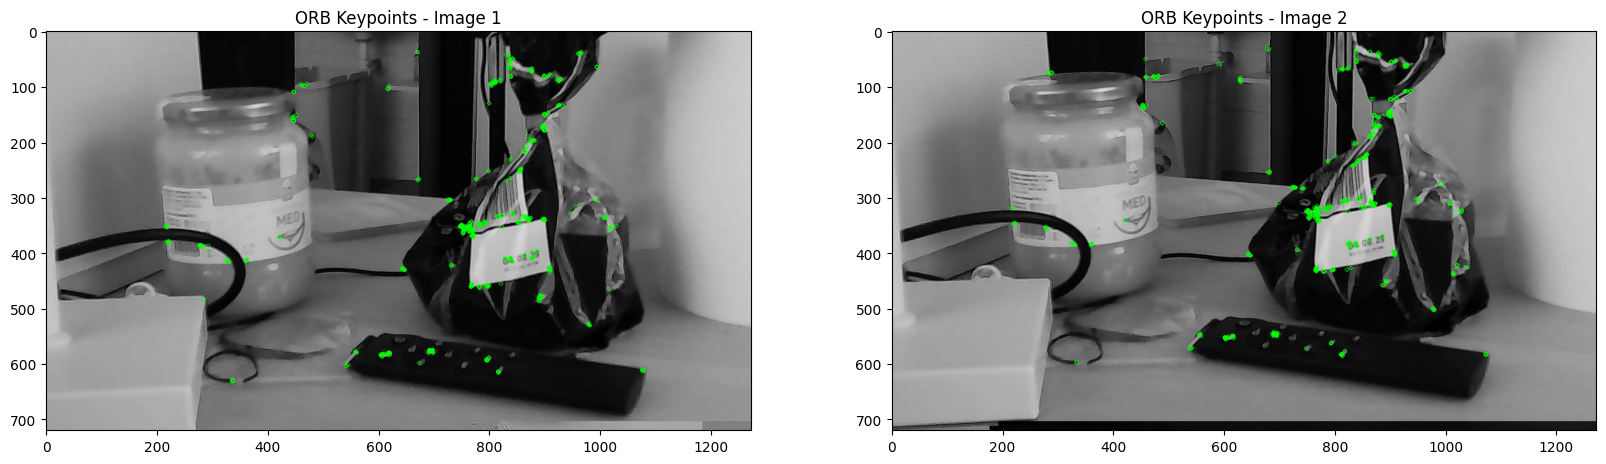

In [87]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
 
# img = cv.imread(IMG_1)
# img = cv.imread(IMG_1, cv.IMREAD_GRAYSCALE)

def extract_features(img):
    # Initiate ORB detector
    orb = cv.ORB_create()
    
    # find the keypoints with ORB
    kp = orb.detect(img, None)
    
    # compute the descriptors with ORB
    kp, des = orb.compute(img, kp)
    
    # OR use
    # kp1, des1 = orb.detectAndCompute(img1,None)
    
    return kp, des
  
def draw_keypoints(img, kp):
    # draw only keypoints location, not size and orientation
    img_with_kp = cv.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
    return img_with_kp
  
img1 = cv.imread(IMG_1, cv.IMREAD_GRAYSCALE)
img2 = cv.imread(IMG_2, cv.IMREAD_GRAYSCALE)
 
kp1, des1 = extract_features(img1)
img_with_kp1 = draw_keypoints(img1, kp1)

# for k in kp:
#     print(f"Keypoint: {k.pt}, Size: {k.size}, Angle: {k.angle}, Response: {k.response}, Octave: {k.octave}")

# for d in des:
#     print(f"Descriptor: {d}")

kp2, des2 = extract_features(img2)
img_with_kp2 = draw_keypoints(img2, kp2)

# show the result in the notebook
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(img_with_kp1, cv.COLOR_BGR2RGB))
plt.title('ORB Keypoints - Image 1')
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(img_with_kp2, cv.COLOR_BGR2RGB))
plt.title('ORB Keypoints - Image 2')
plt.show()


# draw only keypoints location,not size and orientation
# img2 = cv.drawKeypoints(cv.cvtColor(img, cv.COLOR_BGR2RGB), kp, None, color=(255,0,0), flags=0)
# plt.imshow(img2), plt.show()
# img3 = cv.drawKeypoints(img, kp, None, color=(255,0,0), flags=0)
# plt.imshow(img3), plt.show()

### Feature matching
- https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html

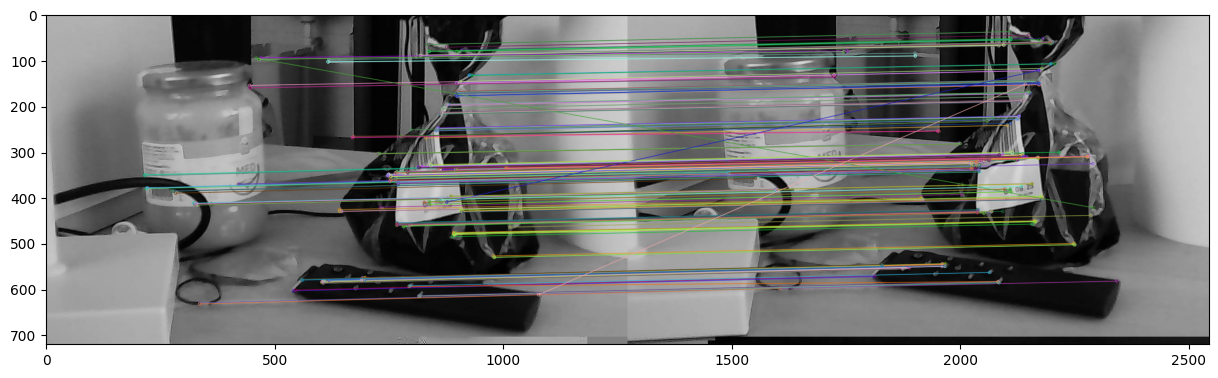

(<matplotlib.image.AxesImage at 0x134b75e50>, None)

In [88]:
# create BFMatcher object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
 
# Draw first 10 matches.
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15, 10))
plt.imshow(img3),plt.show()

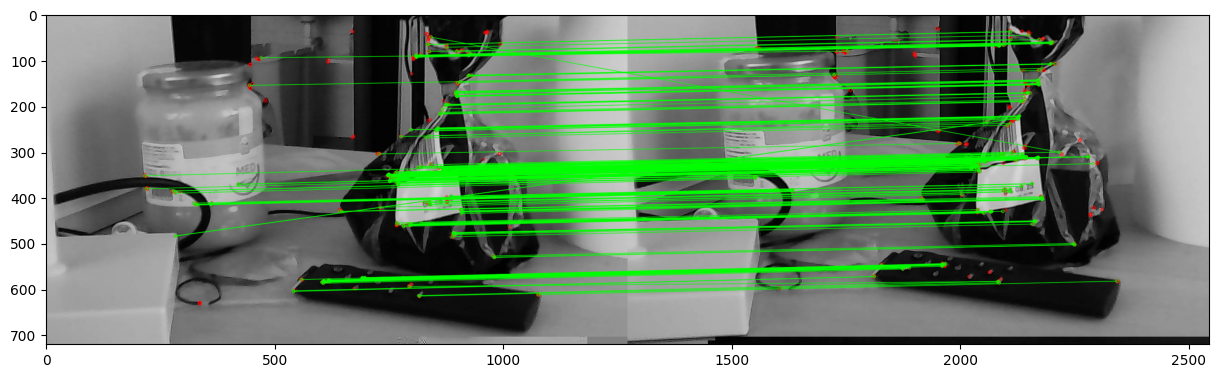

(<matplotlib.image.AxesImage at 0x124ae9590>, None)

In [89]:
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2
search_params = dict()   # or pass empty dictionary

flann = cv.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(des1,des2,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_DEFAULT)

img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

plt.figure(figsize=(15, 10))
plt.imshow(img3,),plt.show()

## Find homography
- https://docs.opencv.org/4.x/d1/de0/tutorial_py_feature_homography.html

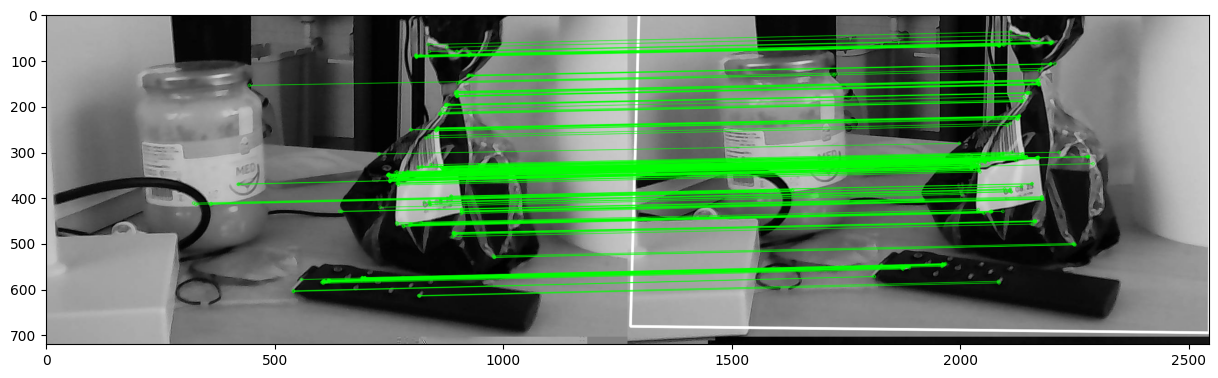

(<matplotlib.image.AxesImage at 0x12481f390>, None)

In [92]:
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
matchesMask = mask.ravel().tolist()

h,w = img1.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv.perspectiveTransform(pts,M)

img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
 
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

plt.figure(figsize=(15, 10))
plt.imshow(img3, 'gray'),plt.show()